In [191]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [226]:
data = pd.read_csv('labeled_data.csv', index_col = [0]) # read in data

In [227]:
data.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [228]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24783 entries, 0 to 25296
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   count               24783 non-null  int64 
 1   hate_speech         24783 non-null  int64 
 2   offensive_language  24783 non-null  int64 
 3   neither             24783 non-null  int64 
 4   class               24783 non-null  int64 
 5   tweet               24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.3+ MB


In [229]:
from tensorflow.keras.layers import TextVectorization

In [230]:
data = pd.get_dummies(data, columns = ['class'], dtype = int) # one hot encode

In [231]:
data = data.drop(columns = ['hate_speech', 'offensive_language', 'neither', 'count'])

In [232]:
data = data.rename(columns = {'class_0':'hate_speech', 'class_1':'offensive_language', 'class_2':'neither'})

In [233]:
X = data['tweet'] # define features (X) and target (y)
y = data[data.columns[1:]].values

In [234]:
max_words = 250000

In [235]:
# create vectorizer
vectorizer = TextVectorization(max_tokens = max_words,
                              output_sequence_length = 1800,
                              output_mode = 'int')

In [236]:
vectorizer.adapt(X.values) # vectorizer learns all vocab

In [237]:
vocab = vectorizer.get_vocabulary() # words identified by vectorizer

In [238]:
vectorized_tweets = vectorizer(X.values)

In [239]:
vectorized_tweets

<tf.Tensor: shape=(24783, 1800), dtype=int64, numpy=
array([[    4, 22772,    74, ...,     0,     0,     0],
       [    4, 22265,   225, ...,     0,     0,     0],
       [    4,  6309,   787, ...,     0,     0,     0],
       ...,
       [  372,  3160,   130, ...,     0,     0,     0],
       [ 4940,    43,  1074, ...,     0,     0,     0],
       [ 9305, 21174, 32163, ...,     0,     0,     0]])>

In [240]:
# create tensorflow data pipeline
dataset = tf.data.Dataset.from_tensor_slices((vectorized_tweets, y))
dataset = dataset.cache()
dataset = dataset.shuffle(25000)
dataset = dataset.batch(32)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [242]:
# define test, train, and validation data from pipeline
train = dataset.take(int(len(dataset)*.7))
test = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*0.1))
val = dataset.skip(int(len(dataset)*.8)).take(int(len(dataset)*0.2))

In [244]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [245]:
# create NN
model = Sequential()
# add embedding layer
model.add(Embedding(max_words + 1, 32)) #could choose 4th root of no f words
# add bidirectional LSTM layer
model.add(Bidirectional(LSTM(32, activation = 'tanh')))
# add hidden layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(3, activation = 'sigmoid'))

In [246]:
model.compile(loss='BinaryCrossentropy', optimizer = 'Adam') # compile model

In [248]:
history = model.fit(train, epochs = 10, validation_data = val) # train model

Epoch 1/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 620s 1s/step - loss: 0.3373 - val_loss: 0.1782
Epoch 2/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 570s 1s/step - loss: 0.1788 - val_loss: 0.1413
Epoch 3/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 828s 2s/step - loss: 0.1390 - val_loss: 0.0977
Epoch 4/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 570s 1s/step - loss: 0.1026 - val_loss: 0.0697
Epoch 5/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 687s 1s/step - loss: 0.0692 - val_loss: 0.0354
Epoch 6/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 601s 1s/step - loss: 0.0454 - val_loss: 0.0290
Epoch 7/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 606s 1s/step - loss: 0.0277 - val_loss: 0.0226
Epoch 8/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 605s 1s/step - loss: 0.0243 - val_loss: 0.0117
Epoch 9/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 582s 1s/step - loss: 0.0167 - val_loss: 0.0122
Epoch 10/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 596s 1s/step - loss: 0.0106 - val_loss: 0.0087


In [218]:
model.summary() # summary of model

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 1800, 32)       │     8,000,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,273,899 (92.60 MB)

 Trainable params: 8,091,299 (30.87 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,182,600 (61.73 MB)

In [310]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

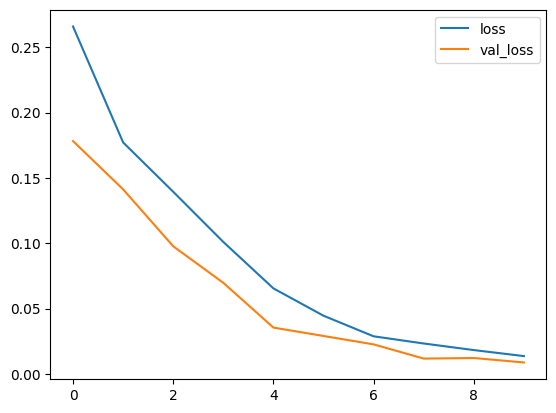

In [312]:
# plot loss over epochs from training
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [394]:
from tensorflow.keras.metrics import Recall, Precision, Accuracy, F1Score

In [395]:
# evaluate model
recall = Recall()
precision = Precision()
accuracy = Accuracy()

In [396]:
for batch in test.as_numpy_iterator():
    X_true, y_true = batch
    y_pred = model.predict(X_true)
    
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    y_pred = (y_pred>0.5).astype('int')
    precision.update_state(y_true, y_pred)
    recall.update_state(y_true, y_pred)
    accuracy.update_state(y_true, y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2024-10-15 13:53:41.861935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [397]:
print(f'Recall: {recall.result().numpy()} \nAccuracy: {accuracy.result().numpy()} \nPrecision: {precision.result().numpy()}')

Recall: 0.9935064911842346 
Accuracy: 0.9960768222808838 
Precision: 0.9947175979614258


In [343]:
f1_score = 2 * ((precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy()))

In [344]:
f1_score

0.9951298832893372

In [386]:
from sklearn.metrics import confusion_matrix, classification_report

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

for batch in test.as_numpy_iterator():
    X_true, y_true = batch
    y_pred = model.predict(X_true)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    all_preds.extend(y_pred_labels.flatten())
    all_labels.extend(y_true_labels.flatten())

# Create and display the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

print("Confusion Matrix:")
print(cm)

# Get a detailed classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2024-10-15 13:47:15.436383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [403]:
model.save('model.keras', include_optimizer = False)

In [404]:
tf.keras.models.load_model('model.keras')

<Sequential name=sequential_7, built=True>

In [412]:
def predict(str):
    tokenised = vectorizer([str])
    result = model.predict(tokenised)
    result = np.argmax(result, axis = 1)
    
    if result == 0:
        text = 'Comment was identified as hate speech.'
    elif result == 1:
        text = 'Comment was identified as offensive language.'
    else:
        text = 'Comment was identified as neither hate speech or offensive language.'
    return text
        

In [414]:
import gradio as gr

In [418]:
interface = gr.Interface(fn = predict, 
                         inputs = gr.Textbox(lines = 2, placeholder = 'Text to score'),
                         outputs = 'text')                

## Make predictions

In [419]:
interface.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
